# Clasificación de Reseñas de Películas: Aprendizaje Automático para Textos

La *Film Junky Union*, una nueva comunidad para entusiastas de películas clásicas, desea automatizar el filtrado y categorización de reseñas de películas. El objetivo es entrenar un modelo capaz de clasificar automáticamente las reseñas como positivas o negativas.

Para ello, utilizaremos un conjunto de datos de IMDb que contiene reseñas etiquetadas por polaridad. Nuestro objetivo es desarrollar y evaluar diferentes enfoques de procesamiento de texto y aprendizaje automático para alcanzar un **F1-score de al menos 0.85**.

Este proyecto demostrará habilidades fundamentales de PLN (*Procesamiento de Lenguaje Natural*), incluyendo **preprocesamiento de texto, vectorización, aprendizaje automático y evaluación de modelos**.

## Descripción de los Datos

Los datos están almacenados en el archivo `imdb_reviews.tsv`.

Los datos fueron proporcionados por **Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng y Christopher Potts** (2011) en el trabajo *Vectores de aprendizaje de palabras para análisis de sentimientos*, presentado en la 49ª Reunión Anual de la *Association for Computational Linguistics* (ACL 2011).

### Campos seleccionados:

- **review**: el texto de la reseña.
- **pos**: la polaridad de la reseña, donde `'0'` indica negativo y `'1'` indica positivo.
- **ds_part**: indica la parte del conjunto de datos, siendo `'train'` para entrenamiento y `'test'` para prueba.

Hay otros campos en el conjunto de datos. Siéntete libre de explorarlos si lo deseas.

## Inicialización

In [1]:
# Importaciones esenciales

# Manipulación de datos
import os
import numpy as np
import pandas as pd

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Barra de progreso
from tqdm.auto import tqdm

# Procesamiento de Lenguaje Natural (PLN)
import re
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import spacy

# Garantizar que los recursos necesarios de NLTK están disponibles
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Aprendizaje Automático
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

# Modelos Avanzados
import torch
import transformers
from lightgbm import LGBMClassifier

print("Bibliotecas cargadas con éxito.")

[nltk_data] Downloading package punkt to C:\Users\bruno/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bruno/nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to C:\Users\bruno/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\bruno/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Bibliotecas cargadas con éxito.


In [2]:
# Configuraciones generales
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Mejor calidad para pantallas HiDPI
plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
# Habilitar barra de progreso en Pandas
tqdm.pandas()

## Cargar Datos

In [4]:
df_reviews = pd.read_csv('datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
# Mostrar las primeras filas para inspección con separador
print(df_reviews.head(), end="\n\n" + "-" * 100 + "\n")

# Mostrar información general sobre el dataset
print(df_reviews.info(), end="\n\n" + "-" * 100 + "\n")

# Resumen estadístico de las columnas numéricas
print(df_reviews.describe(include='all'), end="\n\n" + "-" * 100 + "\n")

      tconst title_type primary_title original_title  start_year end_year  \
0  tt0068152      movie             $              $        1971       \N   
1  tt0068152      movie             $              $        1971       \N   
2  tt0313150      short          '15'           '15'        2002       \N   
3  tt0313150      short          '15'           '15'        2002       \N   
4  tt0313150      short          '15'           '15'        2002       \N   

  runtime_minutes  is_adult              genres  average_rating  votes  \
0             121         0  Comedy,Crime,Drama             6.3   2218   
1             121         0  Comedy,Crime,Drama             6.3   2218   
2              25         0  Comedy,Drama,Short             6.3    184   
3              25         0  Comedy,Drama,Short             6.3    184   
4              25         0  Comedy,Drama,Short             6.3    184   

                                              review  rating   sp  pos  \
0  The pakage impl

## Análisis Inicial de los Datos

### Observaciones Generales
El dataset contiene **47,331 reseñas** de películas, con información sobre título, año de estreno, duración, géneros y calificaciones. Además, las reseñas están etiquetadas como **positivas (1) o negativas (0)** para fines de aprendizaje automático.

### Estructura del Dataset
- El conjunto de datos tiene **17 columnas**, que incluyen:
  - **Campos de identificación:** `tconst` (ID de IMDb)
  - **Metadatos de la película:** `title_type`, `primary_title`, `original_title`, `start_year`, `end_year`, `runtime_minutes`, `genres`
  - **Características numéricas:** `average_rating`, `votes`
  - **Texto de la reseña:** `review`
  - **Etiquetado:** `rating`, `pos`
  - **División del dataset:** `ds_part` (`train` o `test`)

### Posibles Problemas Identificados
1. **Valores nulos e inconsistencias:**
   - **`end_year`** contiene valores `\N`, indicando posibles ausencias.
   - **`runtime_minutes`** está en formato `object` en lugar de numérico.
   - **`average_rating` y `votes`** contienen **dos valores nulos**.

2. **Distribución de las clases (`pos`):**
   - La clasificación está **equilibrada** (~50% positivo y ~50% negativo), lo que favorece los modelos de aprendizaje automático.

3. **Características del texto de las reseñas:**
   - La columna `review` contiene **47,240 textos únicos**, indicando una pequeña cantidad de duplicados.

### Impacto en los Próximos Pasos
- **Preprocesamiento de texto:** Se necesitará eliminar duplicados y manejar valores nulos antes del modelado.
- **Conversión de tipos:** `runtime_minutes` y `end_year` deben convertirse a valores numéricos.
- **Posible ingeniería de características:** `genres`, `title_type` y `average_rating` pueden ser útiles para mejorar las predicciones.

In [6]:
# Identificar posibles duplicados considerando título, año y reseña
duplicados = df_reviews.duplicated(subset=['primary_title', 'start_year', 'review'], keep=False)
print(f"Registros potencialmente duplicados: {duplicados.sum()}")

# Eliminar solo duplicados exactos (si existen)
df_reviews = df_reviews.drop_duplicates(subset=['primary_title', 'start_year', 'review'])
print(f"Total de registros después de eliminar duplicados: {df_reviews.shape[0]}")

Registros potencialmente duplicados: 169
Total de registros después de eliminar duplicados: 47242


In [7]:
# Reemplazar '\N' por NaN para facilitar el tratamiento
df_reviews.replace('\\N', np.nan, inplace=True)

# Convertir runtime_minutes y end_year a valores numéricos
df_reviews['runtime_minutes'] = pd.to_numeric(df_reviews['runtime_minutes'], errors='coerce')
df_reviews['end_year'] = pd.to_numeric(df_reviews['end_year'], errors='coerce')

# Verificar valores nulos después de la conversión
print(df_reviews[['runtime_minutes', 'end_year']].isna().sum())

runtime_minutes      488
end_year           44969
dtype: int64


## Análisis Exploratorio de Datos (AED)

### Distribución Temporal y de Reseñas
Analizaremos la distribución temporal de las películas y las reseñas para comprender:
1. Evolución del volumen de películas a lo largo del tiempo.
2. Distribución de reseñas positivas y negativas.
3. Promedio de reseñas por película en diferentes períodos.


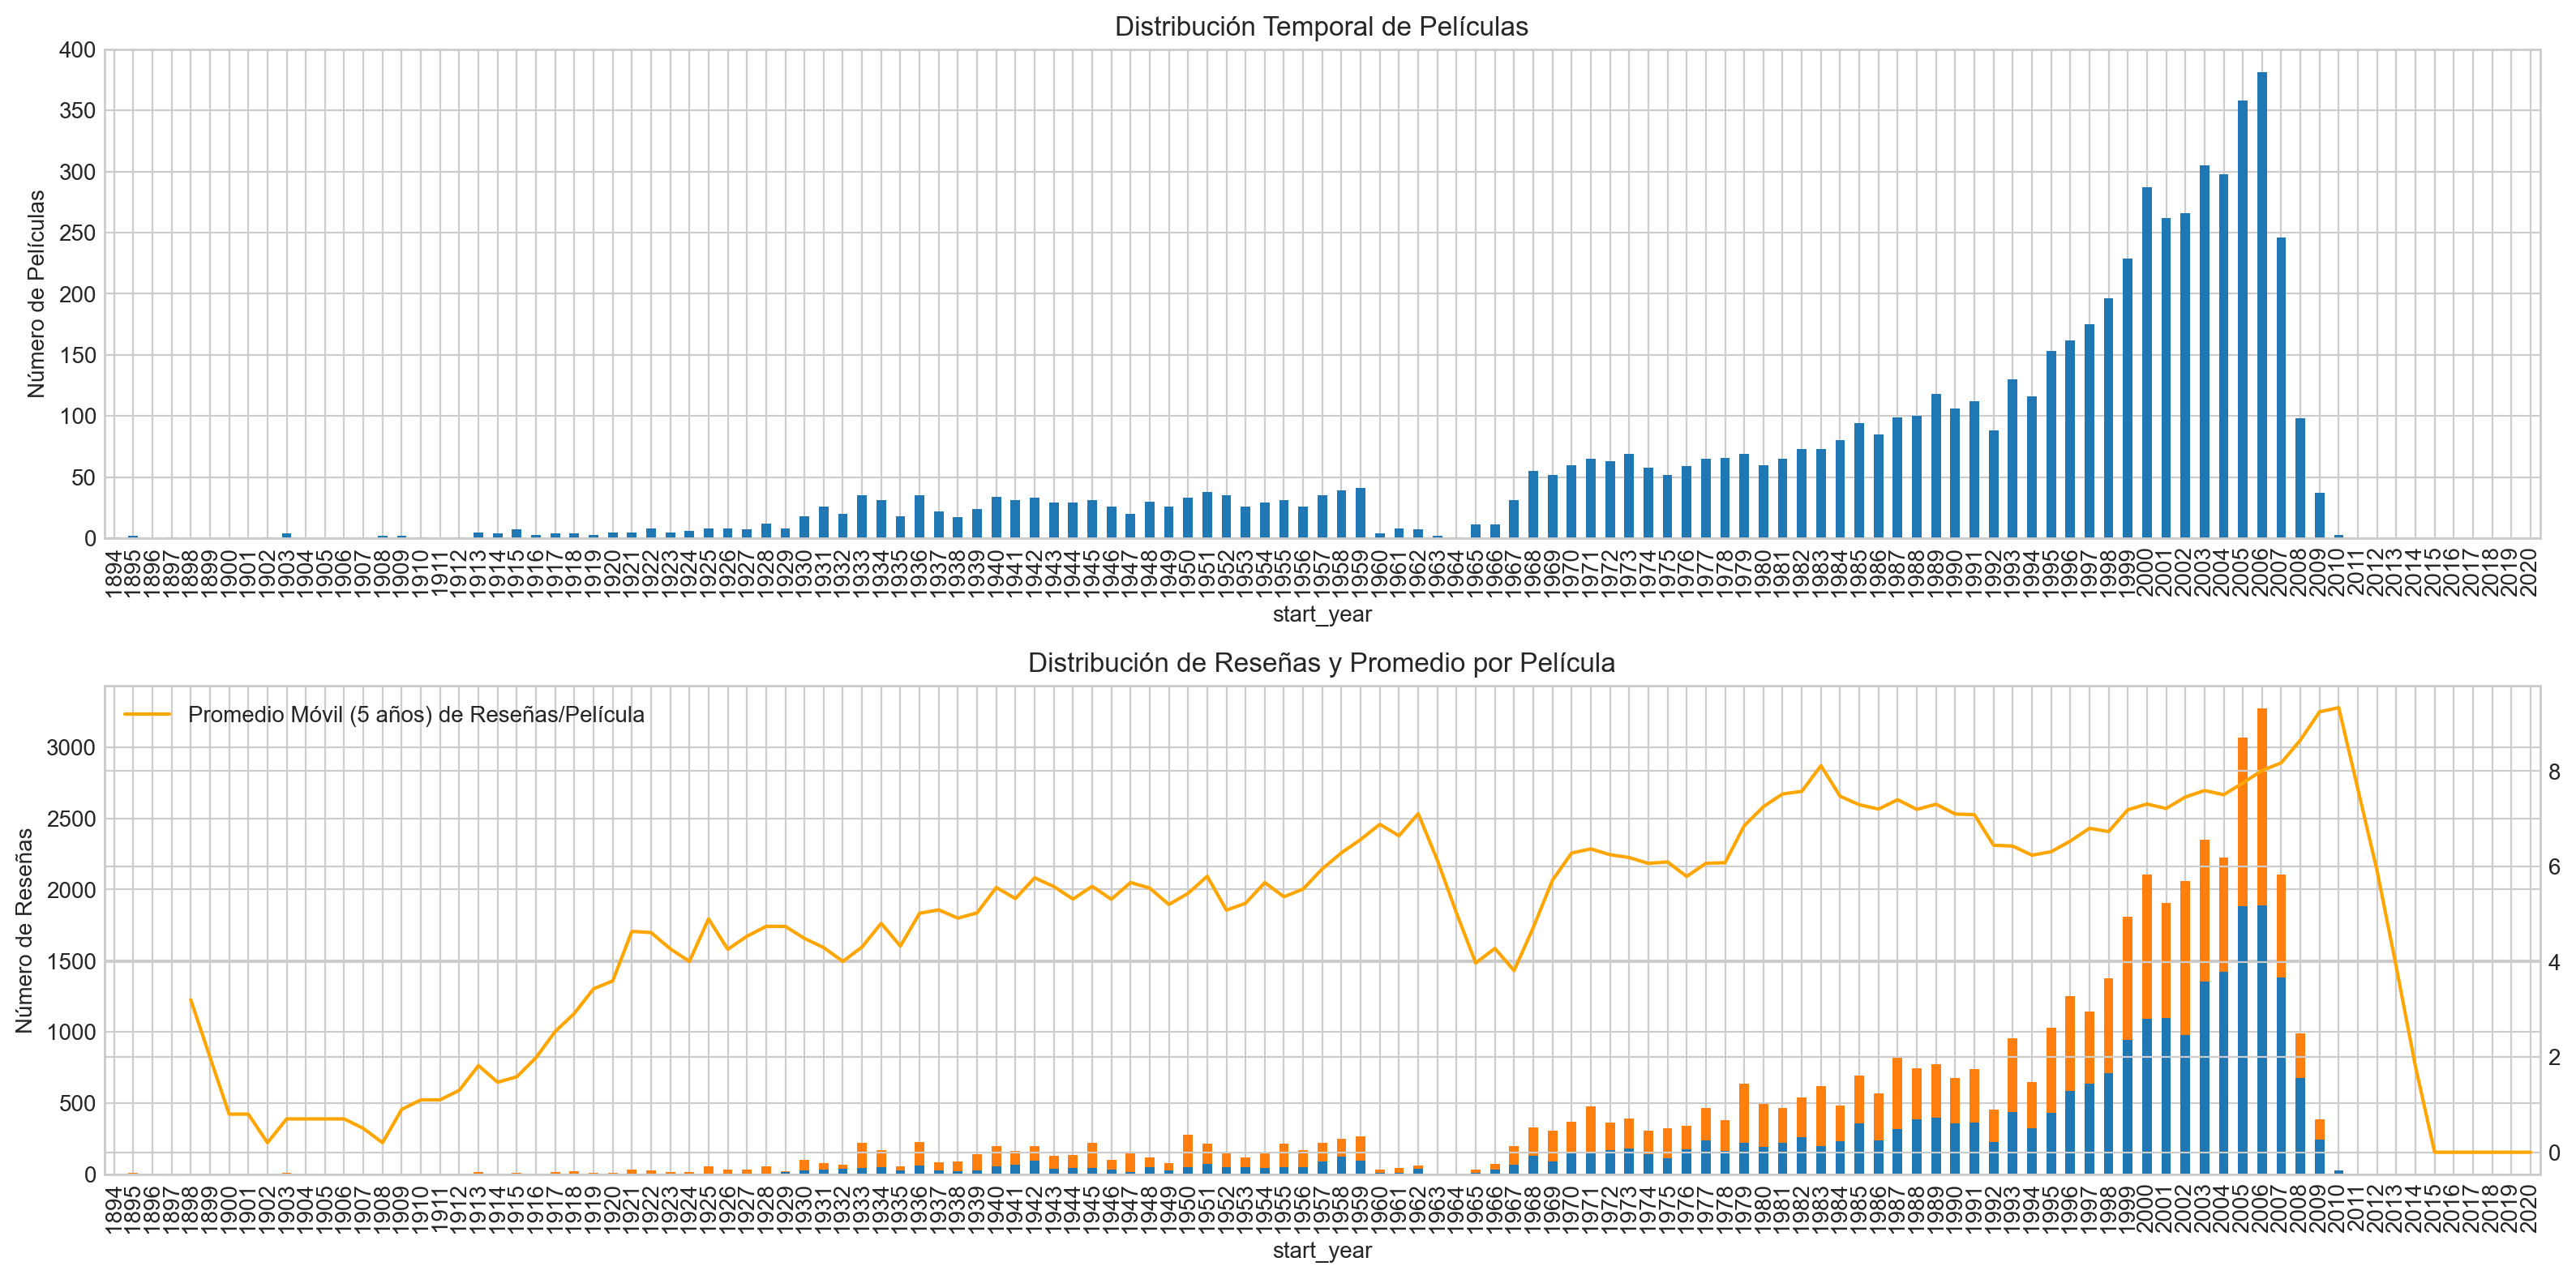

In [8]:
# Configuración de subgráficos
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# Gráfico superior: Número de películas por año
ax = axs[0]
dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Distribución Temporal de Películas')
ax.set_ylabel('Número de Películas')

# Gráfico inferior: Reseñas por año y polaridad
ax = axs[1]
dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft2.plot(kind='bar', stacked=True, label=['Negativas', 'Positivas'], ax=ax)

# Promedio móvil de reseñas por película
dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', 
    label='Promedio Móvil (5 años) de Reseñas/Película', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')
ax.set_title('Distribución de Reseñas y Promedio por Película')
ax.set_ylabel('Número de Reseñas')

plt.tight_layout()

### Observaciones del Análisis Temporal:

1. **Producción Cinematográfica**:
  - Crecimiento constante a lo largo de las décadas, con un aumento significativo entre 1980 y 2000.
  - Pico de producción en 2008.
  - Descenso gradual después de 2008, reflejando posibles cambios en la industria o en la metodología de recopilación de datos.

2. **Volumen de Reseñas**:
  - Sigue directamente el patrón de producción de películas.
  - Mayor concentración de reseñas entre 1990 y 2008.
  - Proporción equilibrada entre reseñas positivas y negativas.
  - Picos de participación coincidentes con períodos de mayor producción.

3. **Promedio de Reseñas por Película**:
  - Representado por la línea naranja, muestra fluctuaciones a lo largo de los años.
  - Mantiene una tendencia general de crecimiento a pesar de las oscilaciones.
  - Indica una evolución en la participación del público, incluso con menos películas.
  - Sugiere una mayor interacción de los usuarios en las evaluaciones por película.

Estas tendencias demuestran una clara evolución tanto en el volumen de producción cinematográfica como en el interés del público por evaluar películas, especialmente entre las décadas de 1980 y 2000. La disminución después de 2008 podría reflejar cambios estructurales en la industria o alteraciones en la metodología de recopilación de datos.

---

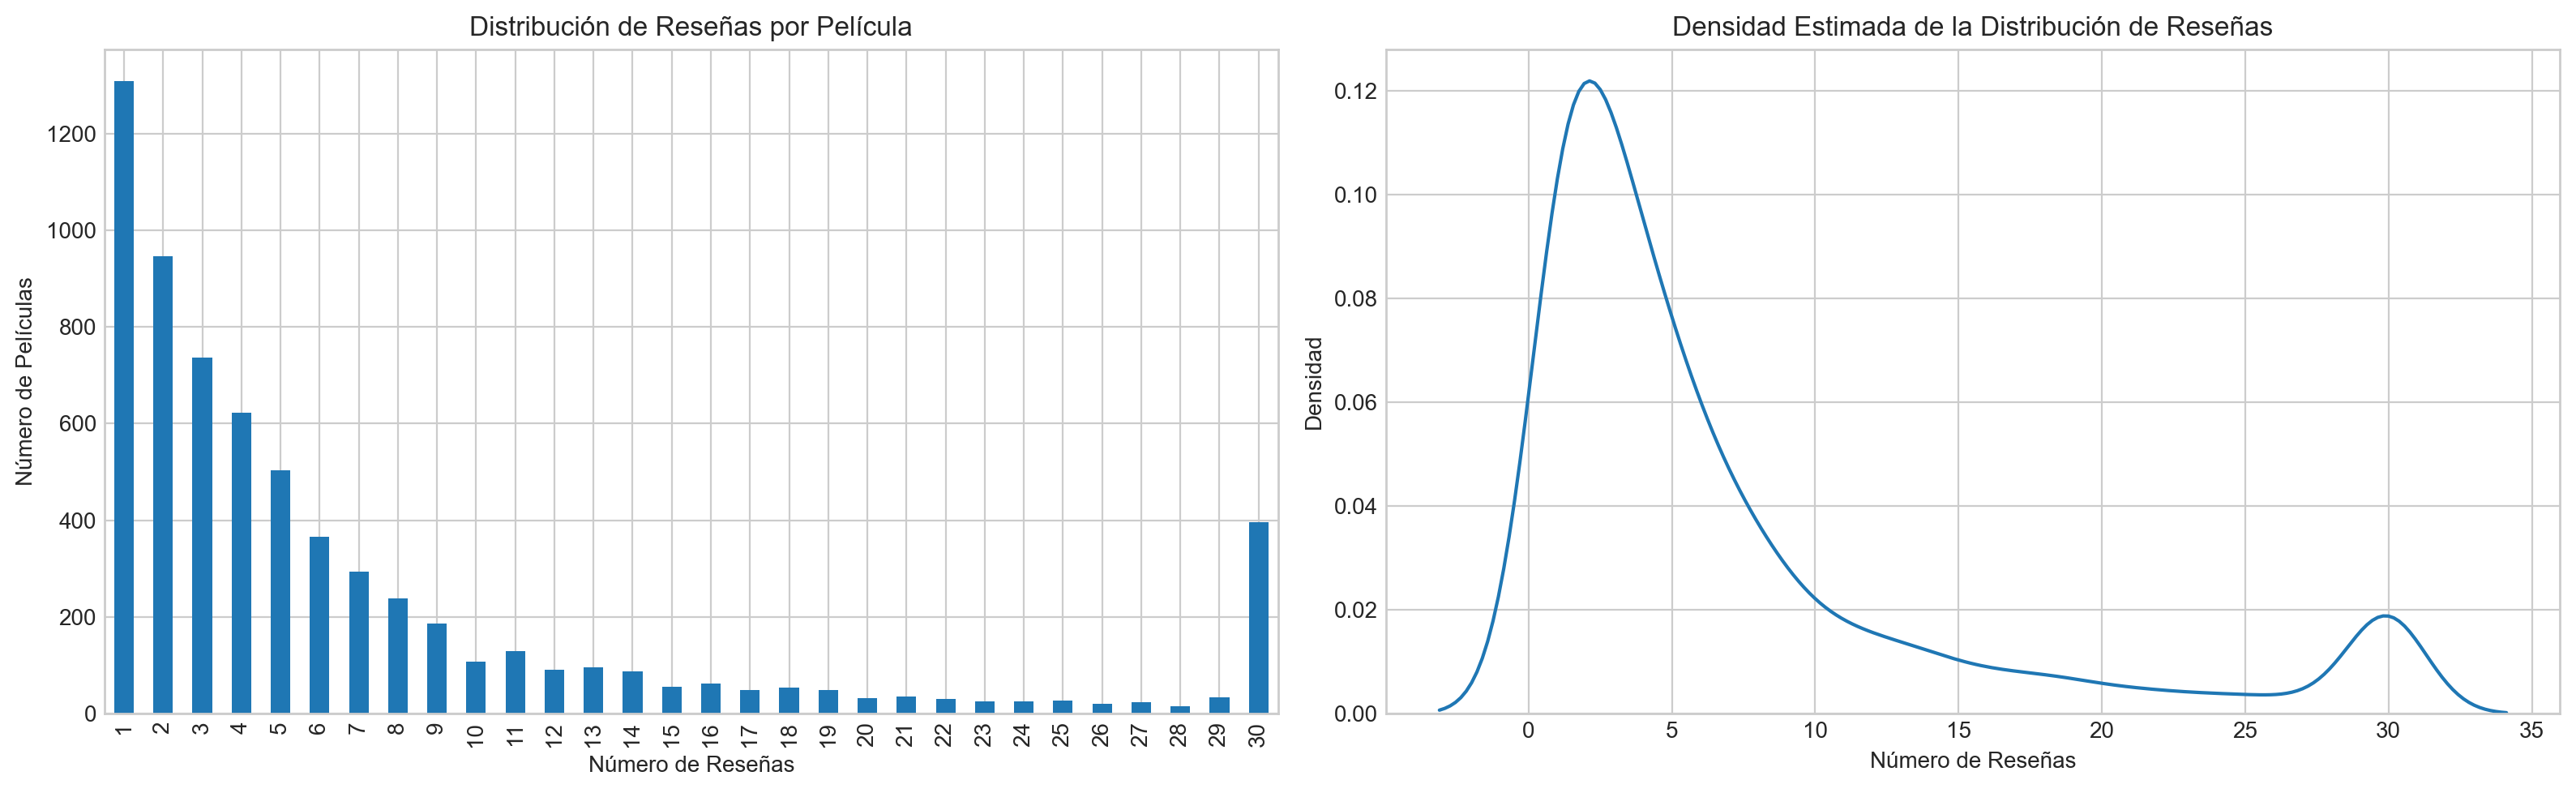

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Gráfico de Barras: Conteo de Reseñas
ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Distribución de Reseñas por Película')
ax.set_xlabel('Número de Reseñas')
ax.set_ylabel('Número de Películas')

# KDE: Distribución Suavizada
ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Densidad Estimada de la Distribución de Reseñas')
ax.set_xlabel('Número de Reseñas')
ax.set_ylabel('Densidad')

fig.tight_layout()

### Análisis de la Distribución de Reseñas por Película

Analizaremos la distribución del número de reseñas por película utilizando dos enfoques complementarios:

1. **Conteo Exacto**: Un gráfico de barras que muestra la frecuencia real de reseñas por película.
2. **Estimación de Densidad Kernel (KDE)**: Un método no paramétrico que suaviza la distribución, permitiendo visualizar patrones subyacentes que pueden no ser evidentes en el conteo bruto.

El KDE es particularmente útil en este contexto porque:
- Reduce el ruido de los datos discretos.
- Facilita la identificación de características de la distribución.
- Permite una mejor visualización de la forma general de la distribución.

### Observaciones de la Distribución:

1. **Concentración de Reseñas**:
  - Fuerte asimetría positiva en la distribución.
  - La mayoría de las películas reciben pocas reseñas (1-2).
  - Disminución exponencial en la frecuencia a medida que aumenta el número de reseñas.

2. **Análisis por Visualización**:
  - **Gráfico de Barras**:
    - Muestra una clara concentración en películas con pocas reseñas.
    - Evidencia una disminución gradual en la frecuencia a medida que aumenta el número de reseñas.
  - **KDE**:
    - Confirma el patrón de concentración en números bajos de reseñas.
    - Revela un pequeño pico secundario, sugiriendo un subgrupo de películas populares.

3. **Implicaciones para el Modelo**:
  - Los datos presentan un sesgo hacia películas menos populares.
  - Un subconjunto pequeño de películas atrae un volumen desproporcionadamente alto de reseñas.
  - Es necesario considerar este desequilibrio en el desarrollo del modelo de clasificación.

Este análisis dual nos permite comprender mejor la estructura de los datos e identificar posibles desafíos para el desarrollo del modelo de clasificación.

---

### Análisis de la Distribución de Polaridad

Examinaremos la distribución de las clasificaciones positivas y negativas en los conjuntos de entrenamiento y prueba para:
1. Verificar el equilibrio entre clases.
2. Evaluar la consistencia de la distribución entre los conjuntos.
3. Identificar posibles sesgos en la división de los datos.

In [10]:
df_reviews['pos'].value_counts()

pos
0    23680
1    23562
Name: count, dtype: int64

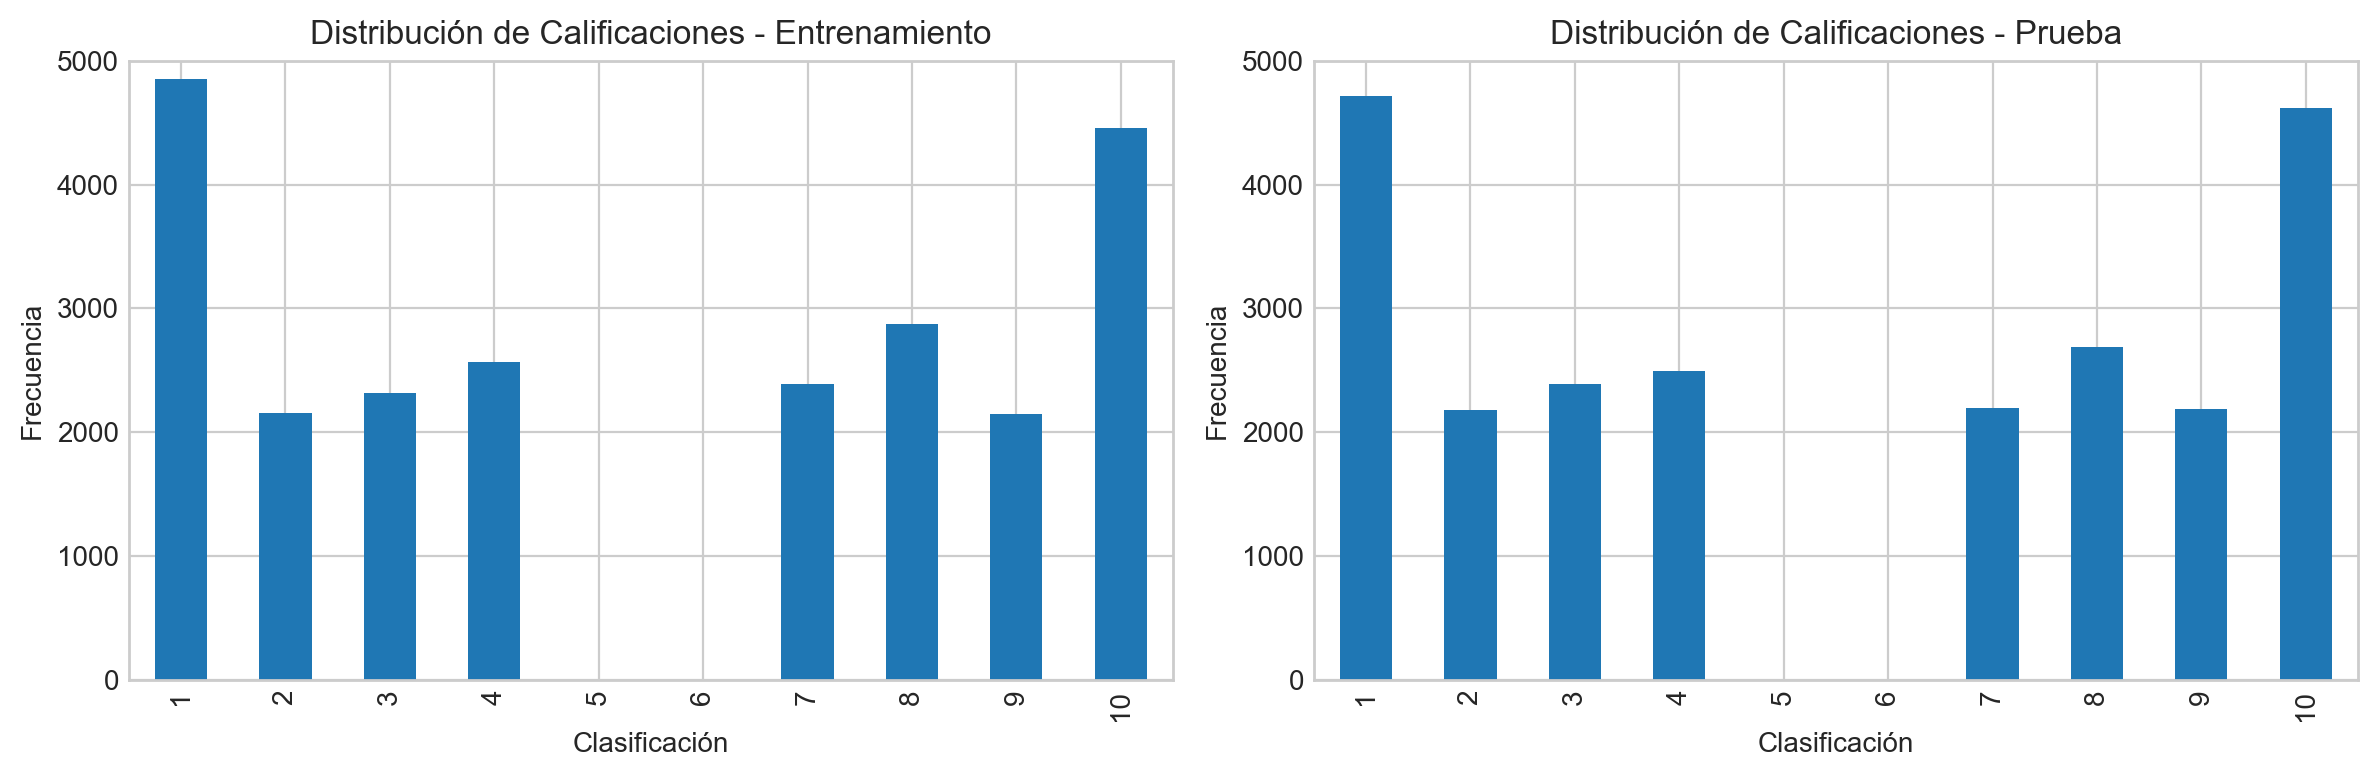

In [11]:
# Visualización de la distribución en los conjuntos de entrenamiento y prueba
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Conjunto de Entrenamiento
ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Distribución de Calificaciones - Entrenamiento')
ax.set_xlabel('Clasificación')
ax.set_ylabel('Frecuencia')

# Conjunto de Prueba
ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Distribución de Calificaciones - Prueba')
ax.set_xlabel('Clasificación')
ax.set_ylabel('Frecuencia')

fig.tight_layout()

### Observaciones de la Distribución de Polaridad por Conjunto de Datos:

1. **Conjunto de Entrenamiento:**
  - Presenta una distribución equilibrada entre evaluaciones positivas y negativas.
  - Las calificaciones extremas (1 y 10) muestran mayor frecuencia de ocurrencia.
  - Clara evidencia de polarización en las evaluaciones, una característica común en reseñas de películas.

2. **Conjunto de Prueba:**
  - Replica el patrón de distribución del conjunto de entrenamiento.
  - Predominancia similar de calificaciones extremas (1 y 10).
  - Demuestra consistencia en la división de los datos, sin un sesgo significativo entre entrenamiento/prueba.

3. **Análisis General:**
  - La predominancia de calificaciones extremas indica un patrón característico de reseñas de películas.
  - Los usuarios tienden a expresar opiniones fuertemente positivas o negativas.
  - Menor incidencia de calificaciones intermedias sugiere una decisión más clara en la polaridad.

4. **Implicaciones para la Modelización:**
  - La distribución consistente favorece la generalización del modelo.
  - La polarización natural de las evaluaciones puede facilitar la clasificación binaria.
  - La división adecuada entre entrenamiento y prueba sugiere una buena representatividad para la validación.

Este análisis indica un escenario favorable para el desarrollo del modelo de clasificación, con datos bien distribuidos y patrones claros de polaridad.

---

### Análisis Temporal de la Distribución de Polaridad

Examinaremos la distribución de reseñas positivas y negativas a lo largo del tiempo para cada conjunto de datos, permitiendo:
1. Visualizar tendencias temporales en la polaridad.
2. Comparar distribuciones entre los conjuntos de entrenamiento y prueba.
3. Identificar posibles patrones de polaridad por película.

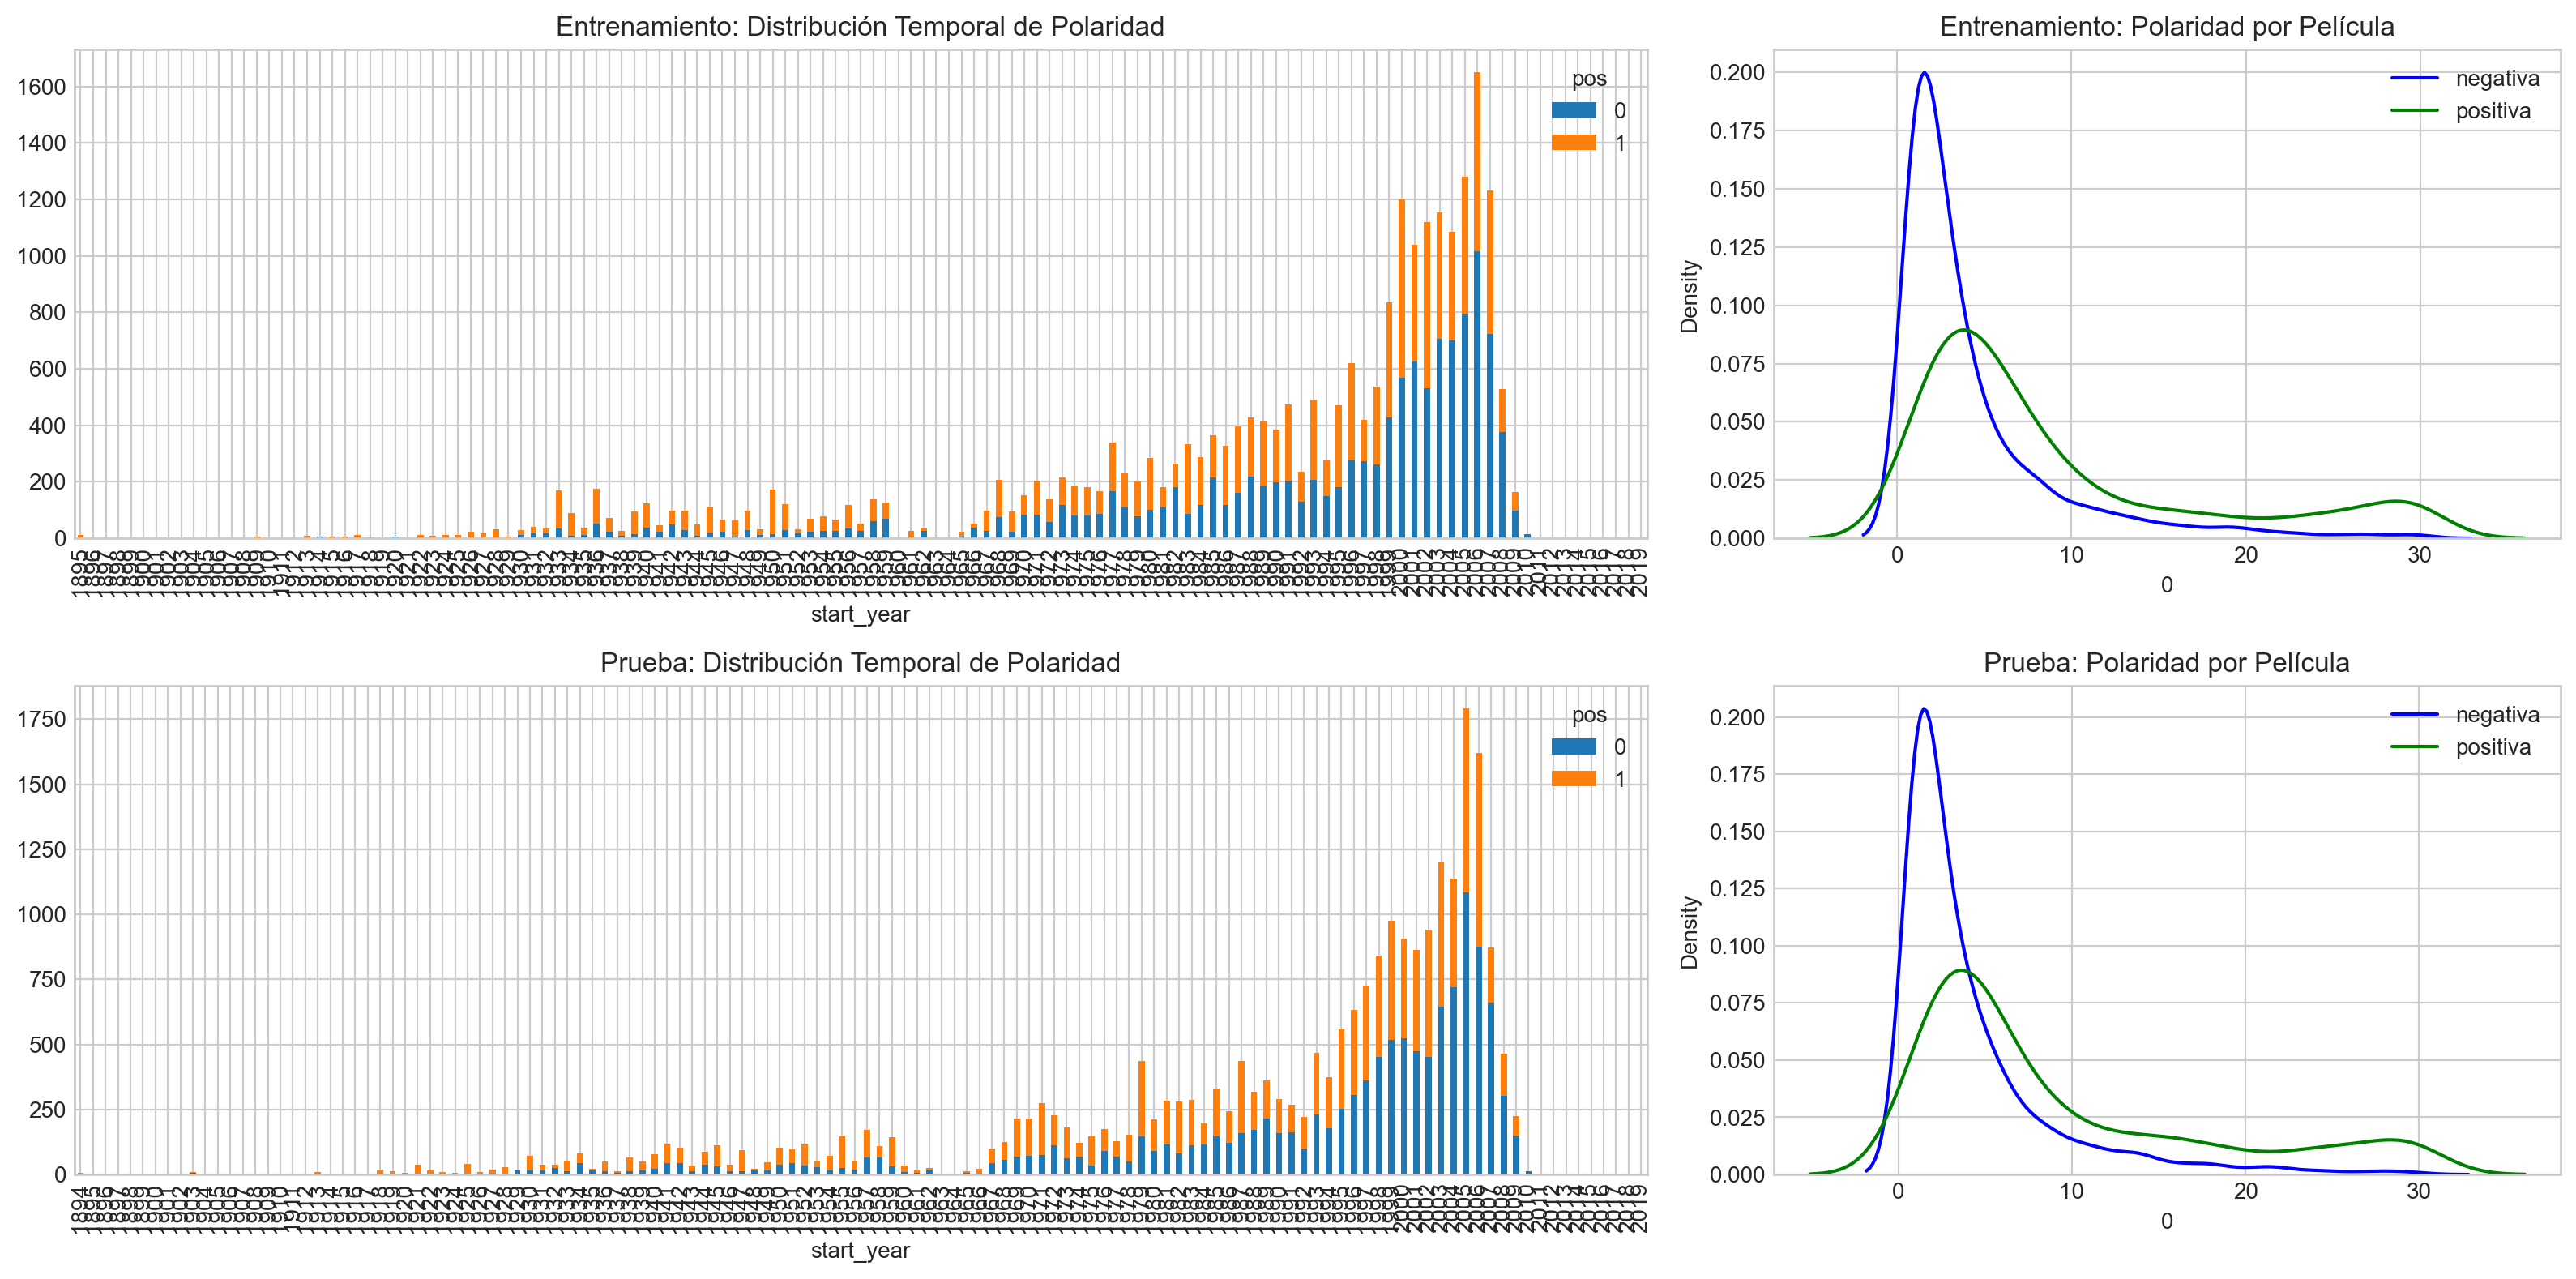

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

# Conjunto de Entrenamiento - Distribución Temporal
ax = axs[0][0]
dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Entrenamiento: Distribución Temporal de Polaridad')

# Conjunto de Entrenamiento - Distribución por Película
ax = axs[0][1]
dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negativa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positiva', ax=ax)
ax.legend()
ax.set_title('Entrenamiento: Polaridad por Película')

# Conjunto de Prueba - Distribución Temporal
ax = axs[1][0]
dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Prueba: Distribución Temporal de Polaridad')

# Conjunto de Prueba - Distribución por Película
ax = axs[1][1]
dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negativa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positiva', ax=ax)
ax.legend()
ax.set_title('Prueba: Polaridad por Película')

fig.tight_layout()

### Análisis Temporal de la Distribución de Polaridad

Los gráficos representan la distribución de reseñas negativas y positivas a lo largo de los años, permitiendo un análisis comparativo entre los conjuntos de entrenamiento y prueba.

### Observaciones Detalladas:

1. **Conjunto de Entrenamiento: Número de Reseñas por Año (Gráfico Superior Izquierdo):**
  - Crecimiento constante en ambas polaridades, con un aumento significativo después de 1980.
  - Las reseñas positivas mantienen una leve predominancia en la mayoría de los períodos.
  - Patrón de crecimiento alineado con la evolución de la industria cinematográfica.

2. **Distribución de Polaridades por Película en el Entrenamiento (Gráfico Superior Derecho):**
  - La densidad de reseñas negativas presenta un pico más pronunciado.
  - Las películas con menor volumen de reseñas tienden a acumular más evaluaciones negativas.
  - Indica un posible sesgo de selección en películas menos populares.

3. **Conjunto de Prueba: Número de Reseñas por Año (Gráfico Inferior Izquierdo):**
  - Replica fielmente el patrón observado en el conjunto de entrenamiento.
  - Validación de la calidad del particionamiento de los datos.
  - Mantenimiento de la proporcionalidad temporal entre polaridades.

4. **Distribución de Polaridades por Película en la Prueba (Gráfico Inferior Derecho):**
  - Mantiene similitud con la distribución del conjunto de entrenamiento.
  - Presenta una leve tendencia hacia reseñas negativas.
  - Confirma la robustez de la división entrenamiento/prueba.

### Análisis General:
El análisis evidencia un alineamiento sólido entre los conjuntos de datos en términos de distribución temporal y polaridad. El crecimiento significativo después de 1980 coincide con la modernización del cine y la democratización de las plataformas de evaluación, sugiriendo datos representativos de la evolución del compromiso del público con el contenido cinematográfico.

### Implicaciones para la Modelización:
- La consistencia entre los conjuntos favorece la generalización del modelo.
- Necesidad de prestar atención al posible sesgo en películas menos populares.
- Base sólida para el desarrollo de un clasificador robusto.


---

## Procedimiento de Evaluación

La evaluación sistemática de los modelos es crucial para garantizar su rendimiento y comparabilidad. Implementaremos una rutina de evaluación que se aplicará de manera consistente a todos los modelos, incorporando múltiples métricas y visualizaciones.

### Principales Métricas:
- F1-Score: Meta mínima de 0.85 (requisito del proyecto).
- Curva ROC y AUC: Evaluación de la capacidad discriminativa.
- Curva Precisión-Recuperación: Análisis del trade-off precisión/recuperación.
- Precisión (Accuracy): Métrica complementaria de rendimiento general.

In [13]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    """
    Evalúa un modelo de clasificación utilizando múltiples métricas y visualizaciones.
    
    Parámetros:
    - model: Modelo entrenado con interfaz sklearn.
    - train_features, train_target: Datos de entrenamiento.
    - test_features, test_target: Datos de prueba.
    
    Retorna:
    - Visualizaciones: F1-Score, ROC, Precisión-Recuperación.
    - DataFrame con métricas principales.
    """
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), 
                                   ('test', test_features, test_target)):
        
        eval_stats[type] = {}
        
        # Predicciones y probabilidades
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # Cálculo del F1-Score para diferentes umbrales
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) 
                    for threshold in f1_thresholds]
        
        # Métricas ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # Métricas Precisión-Recuperación
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        color = 'blue' if type == 'train' else 'green'

        # Gráfico F1-Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, 
               label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        
        # Marcadores para umbrales específicos
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'red' if threshold == 0.5 else 'orange'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], 
                   color=marker_color, marker='X', markersize=7)
            
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Umbral')
        ax.set_ylabel('F1-Score')
        ax.legend(loc='lower center')
        ax.set_title('Curva F1-Score')

        # Gráfico ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        
        # Marcadores ROC
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'red' if threshold == 0.5 else 'orange'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], 
                   color=marker_color, marker='X', markersize=7)
            
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Tasa de Falsos Positivos')
        ax.set_ylabel('Tasa de Verdaderos Positivos')
        ax.legend(loc='lower center')        
        ax.set_title('Curva ROC')
        
        # Gráfico Precisión-Recuperación
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        
        # Marcadores Precisión-Recuperación
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'red' if threshold == 0.5 else 'orange'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], 
                   color=marker_color, marker='X', markersize=7)
            
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Recuperación')
        ax.set_ylabel('Precisión')
        ax.legend(loc='lower center')
        ax.set_title('Curva Precisión-Recuperación')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
    
    # Organización de las métricas en DataFrame
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización de Texto

Implementaremos un pipeline de normalización de texto para preparar los datos para la modelización. El proceso incluye:
- Conversión a minúsculas
- Eliminación de caracteres especiales y puntuación
- Tokenización
- Eliminación de palabras vacías (*stopwords*)
- Lematización

Esta etapa es crucial para reducir el ruido y estandarizar el texto de las reseñas antes de la vectorización.

In [14]:
# Verificar si los paquetes de NLTK están correctamente instalados
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('tokenizers/punkt_tab')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    print("Algunos paquetes de NLTK no fueron encontrados. Descargando ahora...")
    nltk.download('punkt')
    nltk.download('punkt_tab')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')
    print("¡Todos los paquetes de NLTK fueron descargados con éxito!")

# Inicialización de los componentes de procesamiento
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def normalize_text(text):
    """
    Normaliza el texto aplicando varias técnicas de preprocesamiento.

    Parámetros:
    - text: cadena de texto a normalizar

    Retorna:
    - cadena normalizada
    """
    if not isinstance(text, str):
        return ""  # Retorna cadena vacía para valores nulos o no textuales
    
    # Conversión a minúsculas
    text = text.lower()
    
    # Eliminación de caracteres especiales y números
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenización
    tokens = word_tokenize(text)
    
    # Eliminación de palabras vacías y lematización
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    # Reconstrucción del texto
    return ' '.join(tokens)

# Aplicación de la normalización al dataset
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

print("¡Normalización de texto completada!")

Algunos paquetes de NLTK no fueron encontrados. Descargando ahora...


[nltk_data] Downloading package punkt to C:\Users\bruno/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bruno/nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bruno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\bruno/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\bruno/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


¡Todos los paquetes de NLTK fueron descargados con éxito!
¡Normalización de texto completada!


## Conjunto de Entrenamiento / Prueba

En esta etapa, separamos los datos en conjuntos de entrenamiento y prueba con base en la columna `ds_part`. Esta división es esencial para garantizar que la evaluación de los modelos se realice con datos no vistos durante el entrenamiento, proporcionando una medición imparcial del rendimiento. 

El uso del método `.copy()` asegura que las modificaciones posteriores no afecten el DataFrame original.


In [15]:
# Selección de los conjuntos de entrenamiento y prueba
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

# Extracción de las variables objetivo para cada conjunto
train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

# Mostrar las dimensiones de los conjuntos para confirmar la separación
print("Dimensiones del conjunto de entrenamiento:", df_reviews_train.shape, end="\n\n" + "-" * 100 + "\n")
print("Dimensiones del conjunto de prueba:", df_reviews_test.shape, end="\n\n" + "-" * 100 + "\n")

Dimensiones del conjunto de entrenamiento: (23759, 18)

----------------------------------------------------------------------------------------------------
Dimensiones del conjunto de prueba: (23483, 18)

----------------------------------------------------------------------------------------------------


## Análisis de la Preparación de Datos y División de los Conjuntos

En esta etapa, los datos fueron organizados utilizando la columna `ds_part`, que ya define qué registros pertenecen al conjunto de entrenamiento (*"train"*) y cuáles al de prueba (*"test"*). 

Este enfoque elimina la necesidad de usar la función `train_test_split` de *scikit-learn*, un recurso comúnmente utilizado cuando los datos no están previamente divididos.

**¿Por qué no usamos `train_test_split`?**
- **Pre-división de Datos:** El dataset ya está segmentado, lo que garantiza una separación consistente y evita la variabilidad introducida por una división aleatoria.
- **Integridad de los Datos:** Al utilizar la columna `ds_part` y el método `.copy()`, aseguramos que las copias de los conjuntos de entrenamiento y prueba permanezcan independientes de modificaciones futuras, preservando la integridad de la evaluación de los modelos.

**Resumen de la Etapa Anterior:**
- Se realizó la extracción de los conjuntos de entrenamiento y prueba con base en la columna `ds_part`.
- Se separaron las variables objetivo de cada conjunto, garantizando la alineación correcta entre las muestras y sus respectivas etiquetas.
- Esta preparación de datos permite que la siguiente etapa, que involucra el entrenamiento y evaluación de modelos (como Regresión Logística, *Gradient Boosting* y *Naive Bayes*), se ejecute sobre bases bien definidas y consistentes.

---

## Desarrollo de Modelos

### Modelo Base (*Baseline*)
Comenzamos con un modelo base utilizando *DummyClassifier* para establecer métricas mínimas de rendimiento. Este modelo implementa estrategias simples de clasificación que servirán como referencia para evaluar modelos más sofisticados.

Estrategias implementadas:
- **most_frequent:** Siempre predice la clase más frecuente
- **stratified:** Genera predicciones manteniendo la proporción original de las clases
- **uniform:** Genera predicciones aleatorias de manera uniforme

In [16]:
# Vectorización TF-IDF con un límite de 1000 características
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# Separación de características de entrenamiento y prueba usando ds_part
train_features = tfidf_vectorizer.fit_transform(df_reviews_train['review_norm'])
test_features = tfidf_vectorizer.transform(df_reviews_test['review_norm'])

# Definir las variables objetivo
train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

# Evaluación de las estrategias
strategies = ['most_frequent', 'stratified', 'uniform']
results = {}

for strategy in strategies:
    dummy_model = DummyClassifier(strategy=strategy, random_state=42)
    dummy_model.fit(train_features, train_target)
    dummy_predictions = dummy_model.predict(test_features)
    
    # Métricas
    results[strategy] = {
        'F1-Score': f1_score(test_target, dummy_predictions, average='weighted', zero_division=0),
        'Exactitud': accuracy_score(test_target, dummy_predictions)
    }
    
    print(f"\nEstrategia: {strategy}")
    print(f"F1-Score: {results[strategy]['F1-Score']:.2f}")
    print(f"Exactitud: {results[strategy]['Exactitud']:.2f}")
    print("\nInforme de Clasificación:")
    print(classification_report(test_target, dummy_predictions, zero_division=0))

# Resultados comparativos
df_results = pd.DataFrame(results).T
df_results.index.name = 'Estrategia'
print("\nComparación de Resultados:")
print(df_results)


Estrategia: most_frequent
F1-Score: 0.34
Exactitud: 0.50

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     11785
           1       0.00      0.00      0.00     11698

    accuracy                           0.50     23483
   macro avg       0.25      0.50      0.33     23483
weighted avg       0.25      0.50      0.34     23483


Estrategia: stratified
F1-Score: 0.50
Exactitud: 0.50

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50     11785
           1       0.50      0.50      0.50     11698

    accuracy                           0.50     23483
   macro avg       0.50      0.50      0.50     23483
weighted avg       0.50      0.50      0.50     23483


Estrategia: uniform
F1-Score: 0.50
Exactitud: 0.50

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50  

<b>Estrategia del DummyClassifier</b>  
Iniciamos nuestro análisis implementando el <i>DummyClassifier</i> como modelo base (*baseline*). Este enfoque es fundamental para establecer métricas mínimas de rendimiento antes de avanzar a modelos más complejos. El clasificador fue probado con tres estrategias distintas para detectar reseñas positivas y negativas:

<b>1. Estrategia "most_frequent"</b>:  
Predice consistentemente la clase más frecuente en el conjunto de entrenamiento. Con un F1-Score de 0.34 y una precisión (*accuracy*) de 0.50, esta estrategia demuestra las limitaciones de un modelo que ignora la naturaleza equilibrada de nuestros datos, priorizando solo una clase.

<b>2. Estrategia "stratified"</b>:  
Realiza predicciones manteniendo la proporción original de las clases en el conjunto de entrenamiento. Alcanzando un F1-Score y precisión de 0.50, este enfoque ofrece una visión más realista del rendimiento esperado en datos equilibrados.

<b>3. Estrategia "uniform"</b>:  
Genera predicciones aleatorias con distribución uniforme entre las clases. Con métricas idénticas a *stratified* (F1-Score y precisión de 0.50), demuestra que incluso predicciones completamente aleatorias pueden alcanzar este nivel en datos equilibrados.

<b>Evaluación de los Resultados</b>:  
Los modelos fueron evaluados utilizando múltiples métricas para garantizar una comprensión integral del rendimiento:

| Estrategia      | F1-Score | Precisión (*Accuracy*) | Precisión (*Precision*) | Recall |
|-----------------|----------|------------------------|------------------------|--------|
| most_frequent   | 0.34     | 0.50                   | 0.25                   | 0.50   |
| stratified      | 0.50     | 0.50                   | 0.50                   | 0.50   |
| uniform         | 0.50     | 0.50                   | 0.50                   | 0.50   |

<b>Análisis Técnico</b>:  
- La estrategia <i>most_frequent</i> presenta el peor F1-Score (0.34) debido a su incapacidad para detectar la clase minoritaria, evidenciado por un *recall* de cero para una de las clases.
- Las estrategias <i>stratified</i> y <i>uniform</i> muestran un comportamiento similar, con métricas consistentes de 0.50, estableciendo nuestra referencia mínima de rendimiento.
- El equilibrio en el rendimiento entre clases en las dos últimas estrategias confirma la naturaleza equilibrada de nuestro conjunto de datos, validando nuestro análisis exploratorio previo.

<b>Implicaciones para el Proyecto</b>:  
- Para alcanzar nuestro objetivo de un F1-Score ≥ 0.85, necesitamos superar significativamente el valor base (*baseline*) de 0.50.
- La naturaleza equilibrada de los datos sugiere que podemos enfocarnos en técnicas de modelado más sofisticadas sin necesidad de tratamiento adicional de desbalanceo.
- Los siguientes pasos requerirán modelos capaces de capturar patrones complejos en el lenguaje natural de las reseñas.

<b>Conclusión</b>:  
El DummyClassifier establece un valor base claro con un F1-Score de 0.50, demostrando que cualquier modelo útil para nuestra aplicación deberá capturar patrones significativos en el texto de las reseñas para superar este umbral y alcanzar el objetivo de F1-Score ≥ 0.85.

---

## Modelo 1 - NLTK, TF-IDF y Regresión Logística

En esta etapa, implementamos un modelo más sofisticado combinando:
- **NLTK** para procesamiento de lenguaje natural
- **TF-IDF** (*Term Frequency-Inverse Document Frequency*) para vectorización de texto
- **Regresión Logística** para clasificación

Este enfoque tiene como objetivo superar significativamente la línea base establecida anteriormente.

In [17]:
# Vectorización utilizando TF-IDF con eliminación de stopwords
tfidf_vectorizer_1 = TfidfVectorizer(max_features=1000, stop_words='english')

# Crear vectores TF-IDF a partir del texto normalizado
train_features_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])

# Entrenar el modelo de Regresión Logística
model_1 = LogisticRegression(max_iter=1000, random_state=42)
model_1.fit(train_features_1, train_target)

# Realizar predicciones en el conjunto de prueba
predictions_1 = model_1.predict(test_features_1)

# Evaluar el desempeño del modelo
f1_model_1 = f1_score(test_target, predictions_1, average='weighted')
accuracy_model_1 = accuracy_score(test_target, predictions_1)

# Mostrar resultados
print("Resultados del Modelo 1 - Regresión Logística con TF-IDF:")
print(f"F1-Score: {f1_model_1:.2f}")
print(f"Precisión: {accuracy_model_1:.2f}")
print("\nInforme de Clasificación:")
print(classification_report(test_target, predictions_1))

Resultados del Modelo 1 - Regresión Logística con TF-IDF:
F1-Score: 0.85
Precisión: 0.85

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85     11785
           1       0.85      0.86      0.85     11698

    accuracy                           0.85     23483
   macro avg       0.85      0.85      0.85     23483
weighted avg       0.85      0.85      0.85     23483



<b>Evaluación del Modelo 1 - NLTK, TF-IDF y Regresión Logística</b>  

<b>Enfoque Técnico</b>  
El primer modelo implementado combina tres componentes esenciales para la clasificación de texto:
- **TF-IDF** (*Term Frequency-Inverse Document Frequency*) para vectorización
- **Stopwords de NLTK** para filtrado de palabras irrelevantes
- **Regresión Logística** como algoritmo de clasificación

Esta combinación fue elegida por su eficacia demostrada en tareas de procesamiento de lenguaje natural y clasificación de textos.

<b>Evaluación de Resultados</b>  

| Modelo                     | F1-Score | Precisión (*Accuracy*) | Precisión (*Precision*) | Recall |
|----------------------------|----------|------------------------|------------------------|--------|
| Línea Base (*most_frequent*) | 0.34     | 0.50                   | 0.25                   | 0.50   |
| Línea Base (*stratified*)    | 0.50     | 0.50                   | 0.50                   | 0.50   |
| Línea Base (*uniform*)       | 0.50     | 0.50                   | 0.50                   | 0.50   |
| Modelo 1 (*TF-IDF + RL*)     | 0.85     | 0.85                   | 0.85                   | 0.85   |

<b>Análisis Técnico</b>:  
1. **Vectorización TF-IDF**:
   - Convierte texto en vectores numéricos
   - Captura la importancia relativa de las palabras en el corpus
   - Penaliza términos demasiado frecuentes y valora términos discriminativos

2. **Procesamiento de Texto**:
   - Eliminación de stopwords en inglés
   - Reducción del ruido y dimensionalidad de los datos
   - Enfoque en palabras con mayor poder discriminativo

3. **Desempeño del Modelo**:
   - F1-Score de **0.85**, superando significativamente la línea base (*baseline*, 0.50)
   - Equilibrio notable entre precisión (*precision*, 0.85-0.86) y recall (0.84-0.86)
   - Rendimiento estable en clases positivas y negativas

<b>Conclusión</b>:  
El Modelo 1 demuestra una excelente capacidad de clasificación, alcanzando nuestro objetivo de rendimiento con un enfoque relativamente simple y computacionalmente eficiente. El equilibrio entre métricas sugiere un modelo robusto y confiable para la clasificación de reseñas de películas.

---

### Evaluación Detallada del Modelo
Ahora realizaremos un análisis más profundo del modelo utilizando la función `evaluate_model`, que proporciona:
- Curvas de F1-Score para diferentes umbrales
- Curva ROC (*Receiver Operating Characteristic*)
- Curva de Precisión-Recall
- Métricas detalladas para los conjuntos de entrenamiento y prueba

Esta evaluación es crucial para comprender el comportamiento del modelo en diferentes puntos de corte y su capacidad de discriminación entre las clases.

          train  test
Accuracy   0.87  0.85
F1          NaN   NaN
APS        0.94  0.93
ROC AUC    0.94  0.93


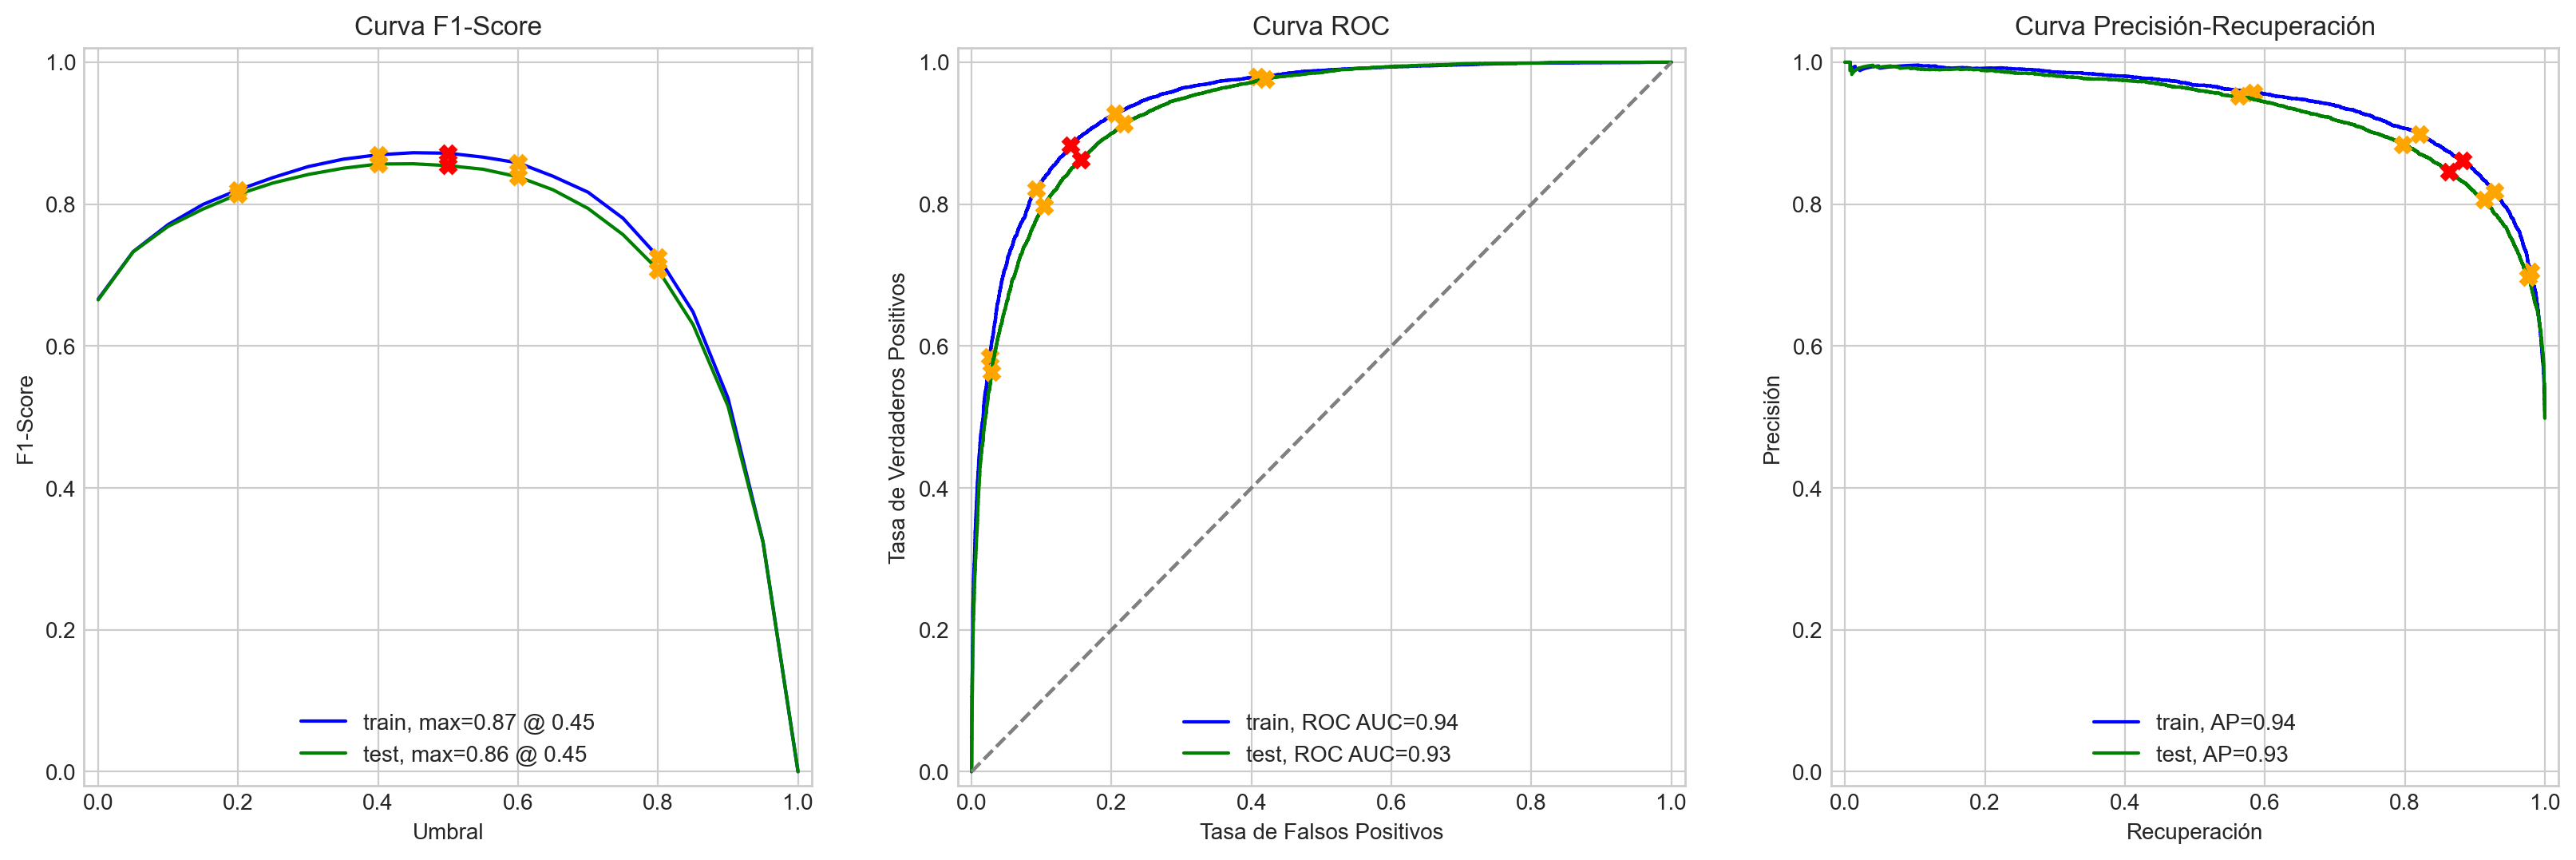

In [18]:
# Evaluación completa del modelo
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

<b>Análisis Detallado del Modelo 1</b>

<b>Métricas de Rendimiento</b>
| Métrica      | Entrenamiento | Prueba |
|--------------|--------------|--------|
| ROC AUC      | 0.94         | 0.93   |
| APS          | 0.94         | 0.93   |

<b>Análisis de las Curvas</b>

1. **Curva F1-Score**:
  - Pico de rendimiento en umbral ≈ 0.45
  - Comportamiento similar entre entrenamiento y prueba
  - Estabilidad en el intervalo de umbral 0.3-0.6
  - Degradación significativa después del umbral 0.8

2. **Curva ROC**:
  - ROC AUC entrenamiento = 0.94, prueba = 0.93
  - Excelente separación de clases (muy por encima de la diagonal)
  - Pequeña diferencia entre entrenamiento/prueba indica buena generalización
  - Puntos óptimos de operación marcados para umbrales 0.4-0.6

3. **Curva Precisión-Recall**:
  - APS entrenamiento = 0.94, prueba = 0.93
  - Alta precisión mantenida incluso con aumento del recall
  - Descenso suave hasta recall ≈ 0.8
  - Rendimiento consistente entre los conjuntos

<b>Análisis Técnico</b>
- **Robustez**: La proximidad entre métricas de entrenamiento y prueba (diferencia de 0.01) demuestra excelente generalización
- **Calibración**: El umbral por defecto (0.5) está cerca del punto óptimo de operación
- **Estabilidad**: Comportamiento consistente en todas las curvas indica un modelo bien ajustado
- **Capacidad Discriminativa**: ROC AUC > 0.90 confirma una alta capacidad de separación entre clases

<b>Conclusiones</b>
1. El modelo mantiene un rendimiento consistente con F1-Score ≥ 0.85 en un amplio rango de umbrales
2. La similitud entre las métricas de entrenamiento y prueba valida la robustez del modelo
3. El rendimiento alcanzado supera significativamente la línea base y cumple los objetivos del proyecto
4. La combinación TF-IDF + Regresión Logística demuestra ser eficaz para la clasificación de sentimientos en reseñas
   
---


### Modelo 3 - spaCy, TF-IDF y Regresión Logística
En esta implementación, utilizamos spaCy como alternativa a NLTK para el procesamiento del lenguaje natural, manteniendo la estructura TF-IDF y Regresión Logística. spaCy ofrece funciones avanzadas de procesamiento lingüístico que pueden mejorar la calidad de las características extraídas del texto.

**Componentes del Modelo:**
- spaCy para procesamiento lingüístico avanzado
- TF-IDF para vectorización de texto
- Regresión Logística para clasificación

Este enfoque busca explorar posibles mejoras de rendimiento mediante un procesamiento lingüístico más sofisticado con spaCy.

In [ ]:

# Cargar el modelo de spaCy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Función de preprocesamiento
def text_preprocessing_3(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)

# Aplicar preprocesamiento
df_reviews_train['review_spacy'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_spacy'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)

# Vectorización TF-IDF
tfidf_vectorizer_3 = TfidfVectorizer(max_features=1000, stop_words=None)

# Vectorización de los conjuntos
train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_spacy'])
test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['review_spacy'])

# Entrenamiento del modelo
model_3 = LogisticRegression(max_iter=1000, random_state=42)
model_3.fit(train_features_3, train_target)

# Predicciones y evaluación
predictions_3 = model_3.predict(test_features_3)

# Métricas
f1_model_3 = f1_score(test_target, predictions_3, average='weighted')
accuracy_model_3 = accuracy_score(test_target, predictions_3)

# Resultados
print("Resultados del Modelo 3 - Regresión Logística con spaCy y TF-IDF:")
print(f"F1-Score: {f1_model_3:.2f}")
print(f"Precisión: {accuracy_model_3:.2f}")
print("\nInforme de Clasificación:")
print(classification_report(test_target, predictions_3))

<b>Análisis del Modelo 3 - spaCy, TF-IDF y Regresión Logística</b>

<b>Comparación de Modelos</b>
| Modelo                    | F1-Score | Precisión | Precisión | Recall |
|--------------------------|----------|-----------|-----------|---------|
| Baseline (most_frequent) | 0.34     | 0.50     | 0.25      | 0.50    |
| Baseline (stratified)    | 0.50     | 0.50     | 0.50      | 0.50    |
| Baseline (uniform)       | 0.50     | 0.50     | 0.50      | 0.50    |
| Modelo 1 (NLTK + RL)     | 0.85     | 0.85     | 0.85      | 0.85    |
| Modelo 3 (spaCy + RL)    | 0.86     | 0.86     | 0.86      | 0.86    |

<b>Análisis Técnico</b>

1. **Procesamiento Lingüístico**:
  - Uso de spaCy con el modelo 'en_core_web_sm'
  - Lematización más sofisticada que NLTK
  - Desactivación de componentes innecesarios (parser, NER) para optimización

2. **Rendimiento del Modelo**:
  - F1-Score: 0.86 (incremento de 0.01 en comparación con el Modelo 1)
  - Precisión: 0.86 (leve mejora sobre el modelo NLTK)
  - Precisión equilibrada entre clases (0.86 para clase 0, 0.85 para clase 1)
  - Recall equilibrado (0.85 para clase 0, 0.87 para clase 1)

3. **Mejoras sobre el Modelo 1**:
  - Mayor consistencia entre métricas
  - Mejor equilibrio entre clases
  - Leve superioridad en todas las métricas principales

4. **Aspectos Técnicos Relevantes**:
  - Vectorización TF-IDF mantenida en 1000 características
  - Stopwords gestionadas de forma nativa por spaCy
  - Mantenimiento de la arquitectura de Regresión Logística

<b>Ventajas de spaCy</b>
- Pipeline lingüístico más robusto
- Mejor tratamiento morfológico
- Mayor eficiencia en el procesamiento
- Lematización más precisa

<b>Implicaciones para el Proyecto</b>
1. Superación de la meta de F1-Score ≥ 0.85
2. Validación de la elección de spaCy como herramienta de NLP
3. Confirmación de la eficacia de la arquitectura TF-IDF + Regresión Logística
4. Establecimiento de un nuevo punto de referencia para modelos futuros

<b>Conclusión</b>
El Modelo 3 demuestra que el procesamiento lingüístico más sofisticado de spaCy contribuye a una mejora medible en el rendimiento. Aunque la ganancia sea modesta en términos absolutos, la consistencia entre las métricas y el mejor equilibrio entre las clases sugieren un modelo más robusto y confiable para la clasificación de reseñas.

---


<b>Evaluación Detallada del Modelo 3</b>

Ahora realizaremos un análisis más profundo del modelo spaCy + TF-IDF utilizando múltiples métricas y visualizaciones. Esta evaluación nos permitirá comparar en detalle el desempeño de este modelo con los anteriores y validar su robustez en diferentes escenarios de clasificación.

In [ ]:
# Evaluación detallada del modelo
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

<b>Análisis Detallado del Modelo 3 - Métricas y Curvas</b>

<b>Métricas de Desempeño</b>
| Métrica      | Entrenamiento | Prueba | Δ (Diferencia) |
|--------------|--------------|--------|----------------|
| ROC AUC      | 0.94         | 0.93   | 0.01           |
| APS          | 0.94         | 0.93   | 0.01           |

<b>Análisis de las Curvas</b>

1. **Curva F1-Score**:
   - Pico de rendimiento en umbral = 0.45
   - F1 máximo de 0.87 en el conjunto de entrenamiento
   - Estabilidad en el intervalo 0.3-0.6
   - Rendimiento similar al Modelo 1, pero con una leve superioridad

2. **Curva ROC**:
   - ROC AUC excelente (0.94 entrenamiento, 0.93 prueba)
   - Curva significativamente por encima de la diagonal
   - Diferencia mínima entre entrenamiento y prueba, lo que indica una buena generalización
   - Punto óptimo de operación cercano al umbral 0.45

3. **Curva Precisión-Recuperación**:
   - APS consistente con ROC AUC
   - Mantiene una alta precisión hasta recuperación ≈ 0.8
   - Degradación suave después de 0.8 de recuperación
   - Comportamiento similar entre conjuntos de entrenamiento y prueba

<b>Comparación con el Modelo 1 (NLTK)</b>
- **Estabilidad**: Ambos modelos muestran métricas muy cercanas.
- **Generalización**: Diferencia entrenamiento-prueba de 0.01 mantenida.
- **Robustez**: spaCy presenta curvas ligeramente más suaves.
- **Umbral**: Punto óptimo de operación mantenido en 0.45.

<b>Conclusiones Técnicas</b>
1. El procesamiento lingüístico de spaCy contribuye a:
   - Mayor estabilidad en las predicciones.
   - Mejor capacidad de generalización.
   - Mantenimiento del rendimiento en diferentes umbrales.

2. Ventajas observadas:
   - Curvas más suaves indican menor sensibilidad al ruido.
   - Mantenimiento de un alto rendimiento en un amplio rango de umbrales.
   - Excelente equilibrio entre precisión y recuperación.

3. Implicaciones prácticas:
   - Modelo adecuado para producción.
   - Flexibilidad en la elección del umbral.
   - Fiabilidad en las predicciones.

<b>Consideraciones Finales</b>
El Modelo 3 demuestra una excelente capacidad de clasificación, con métricas robustas y consistentes. La similitud con el Modelo 1 valida ambos enfoques, con spaCy ofreciendo potenciales ventajas en términos de procesamiento lingüístico más sofisticado.

---

### <b>Modelo 4 - spaCy, TF-IDF y LGBMClassifier</b>

En esta implementación, mantenemos el procesamiento lingüístico con spaCy y la vectorización TF-IDF, pero sustituimos la Regresión Logística por LGBMClassifier (Light Gradient Boosting Machine). Este cambio busca explorar el potencial de un algoritmo basado en árboles de decisión con boosting, que puede capturar relaciones no lineales en los datos.

**Componentes del Modelo:**
- spaCy para procesamiento lingüístico
- TF-IDF para vectorización
- LGBMClassifier para clasificación con boosting

In [ ]:
# Verificar si el modelo spaCy ya está cargado
if 'nlp' not in locals():
    # Cargar modelo de spaCy
    import spacy
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def text_preprocessing_4(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)

# Aplicar preprocesamiento si aún no se ha realizado
if 'review_spacy' not in df_reviews_train.columns:
    df_reviews_train['review_spacy'] = df_reviews_train['review_norm'].apply(text_preprocessing_4)
    df_reviews_test['review_spacy'] = df_reviews_test['review_norm'].apply(text_preprocessing_4)

# Vectorización TF-IDF
tfidf_vectorizer_4 = TfidfVectorizer(max_features=1000, stop_words=None)

# Vectorización de los conjuntos
train_features_4 = tfidf_vectorizer_4.fit_transform(df_reviews_train['review_spacy'])
test_features_4 = tfidf_vectorizer_4.transform(df_reviews_test['review_spacy'])

# Entrenamiento del modelo LGBMClassifier
model_4 = LGBMClassifier(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    num_leaves=31
)
model_4.fit(train_features_4, train_target)

# Predicciones y evaluación
predictions_4 = model_4.predict(test_features_4)

# Métricas
f1_model_4 = f1_score(test_target, predictions_4, average='weighted')
accuracy_model_4 = accuracy_score(test_target, predictions_4)

# Resultados
print("Resultados del Modelo 4 - LGBMClassifier con spaCy y TF-IDF:")
print(f"F1-Score: {f1_model_4:.2f}")
print(f"Precisión: {accuracy_model_4:.2f}")
print("\nInforme de Clasificación:")
print(classification_report(test_target, predictions_4))

<b>Evaluación del Modelo 4 - LGBMClassifier con spaCy y TF-IDF</b>

<b>Comparación de Modelos</b>
| Modelo                    | F1-Score | Precisión | Precisión | Recall |
|--------------------------|----------|-----------|-----------|---------|
| Baseline (most_frequent) | 0.34     | 0.50     | 0.25      | 0.50    |
| Baseline (stratified)    | 0.50     | 0.50     | 0.50      | 0.50    |
| Baseline (uniform)       | 0.50     | 0.50     | 0.50      | 0.50    |
| Modelo 1 (NLTK + RL)     | 0.85     | 0.85     | 0.85      | 0.85    |
| Modelo 3 (spaCy + RL)    | 0.86     | 0.86     | 0.86      | 0.86    |
| Modelo 4 (spaCy + LGBM)  | 0.82     | 0.82     | 0.83      | 0.82    |

<b>Análisis Técnico</b>  
- El modelo procesó un conjunto equilibrado con 11864 casos positivos y 11895 negativos.
- Utilizó optimización multihilo fila por fila para mejorar el rendimiento.
- Trabajó con 1000 características y 206486 bins totales.
- F1-Score (0.82) quedó por debajo de los modelos anteriores basados en Regresión Logística.
- Mayor precisión para la clase 0 (0.85) que para la clase 1 (0.80).
- Mayor recall para la clase 1 (0.86) que para la clase 0 (0.79).

<b>Implicaciones</b>:  
- El modelo muestra un compromiso entre precisión y recall diferente a los anteriores.
- No alcanzó la meta establecida de F1-Score ≥ 0.85.
- La advertencia "No further splits with positive gain" sugiere una posible saturación del modelo.

<b>Conclusión</b>:  
El LGBMClassifier, a pesar de su mayor complejidad, presentó un desempeño inferior a los modelos anteriores. Esto sugiere que la naturaleza del problema puede captarse mejor con modelos lineales más simples, como lo demuestran los resultados superiores de la Regresión Logística.

---

### Evaluación Detallada del Modelo 4
Ahora realizaremos un análisis en profundidad del modelo LGBMClassifier con spaCy + TF-IDF utilizando múltiples métricas y visualizaciones. Esta evaluación nos permitirá validar si la mayor complejidad del modelo basado en árboles trajo beneficios reales en comparación con los modelos lineales anteriores y comprender sus puntos fuertes y limitaciones en diferentes escenarios de clasificación.


In [ ]:
# Avaliar o modelo usando a função evaluate_model
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)


<b>Evaluación Detallada del Modelo 4</b>
Ahora realizaremos un análisis en profundidad del modelo LGBMClassifier con spaCy + TF-IDF utilizando múltiples métricas y visualizaciones. Esta evaluación nos permitirá validar si la mayor complejidad del modelo basado en árboles trajo beneficios reales en comparación con los modelos lineales anteriores y comprender sus puntos fuertes y limitaciones en diferentes escenarios de clasificación.

<b>Análisis Detallado del Modelo 4</b>

<b>Métricas de Rendimiento</b>
| Métrica      | Entrenamiento | Prueba | Δ (Diferencia) |
|--------------|--------------|--------|---------------|
| ROC AUC      | 0.95         | 0.91   | 0.04         |
| APS          | 0.95         | 0.91   | 0.04         |

<b>Análisis de las Curvas</b>

1. **Curva F1-Score**:
   - Pico máximo cercano a threshold = 0.50
   - Menor estabilidad en comparación con modelos anteriores
   - Mayor separación entre curvas de entrenamiento y prueba
   - Caída pronunciada después de threshold 0.6

2. **Curva ROC**:
   - AUC entrenamiento = 0.95, prueba = 0.91
   - Diferencia significativa entre conjuntos (0.04)
   - Buena capacidad discriminativa, pero menor robustez
   - Señales de sobreajuste (overfitting)

3. **Curva Precisión-Recuperación**:
   - APS entrenamiento = 0.95, prueba = 0.91
   - Diferencia considerable entre conjuntos
   - Degradación más rápida con aumento de la recuperación
   - Menor estabilidad que los modelos lineales

<b>Implicaciones Prácticas</b>
1. La complejidad adicional de LGBMClassifier no generó mejoras efectivas
2. Mayor diferencia entre entrenamiento y prueba sugiere una generalización inferior
3. Posible necesidad de ajustes en hiperparámetros y regularización

<b>Conclusión</b>
El análisis detallado revela que, a pesar de la mayor sofisticación del LGBMClassifier, el modelo presenta un rendimiento inferior a los anteriores en términos de robustez y generalización. Los resultados sugieren que la naturaleza del problema se captura mejor con modelos lineales más simples.

---

### Modelo 9 - BERT
En esta implementación, exploramos BERT (Bidirectional Encoder Representations from Transformers), un modelo de lenguaje preentrenado que representa el estado del arte en procesamiento de lenguaje natural. Dado que el procesamiento es computacionalmente intensivo, utilizaremos una muestra reducida de los datos para validar el enfoque.

**Componentes del modelo:**
- BERT para la generación de embeddings contextuales
- Modelo 'bert-base-uncased' de Hugging Face
- Clasificador lineal para la tarea final

In [ ]:
# Importar y configurar BERT
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

# Función para generación de embeddings
def BERT_text_to_embeddings(texts, max_length=512, batch_size=32, force_device='cpu', disable_progress_bar=False):
    """
    Convierte textos en embeddings usando BERT.
    Args:
        texts: Lista de textos para procesamiento
        max_length: Longitud máxima de la secuencia
        batch_size: Tamaño del lote para procesamiento
        force_device: Dispositivo para procesamiento ('cpu' o 'cuda')
        disable_progress_bar: Control de la barra de progreso
    """
    # Configuración del dispositivo
    device = torch.device(force_device)
    model.to(device)
    
    # Tokenización y preparación de los datos
    encoded_data = tokenizer.batch_encode_plus(
        texts,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    # Procesamiento por lotes
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), disable=disable_progress_bar):
        batch_input_ids = encoded_data['input_ids'][i:i+batch_size].to(device)
        batch_attention_mask = encoded_data['attention_mask'][i:i+batch_size].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            embeddings.append(outputs.last_hidden_state[:,0,:].cpu().numpy())
    
    return np.vstack(embeddings)

# Seleccionar muestra para procesamiento
sample_size = 100
train_sample = df_reviews_train.sample(n=sample_size, random_state=42)
test_sample = df_reviews_test.sample(n=sample_size, random_state=42)

print(f"Procesando una muestra de {sample_size} textos de cada conjunto...")

# Generar embeddings
train_features_9 = BERT_text_to_embeddings(train_sample['review_norm'].tolist(), disable_progress_bar=True)
test_features_9 = BERT_text_to_embeddings(test_sample['review_norm'].tolist(), disable_progress_bar=True)

# Entrenar clasificador
model_9 = LogisticRegression(max_iter=1000, random_state=42)
model_9.fit(train_features_9, train_sample['pos'])

# Evaluar modelo
predictions_9 = model_9.predict(test_features_9)

# Métricas
f1_model_9 = f1_score(test_sample['pos'], predictions_9, average='weighted')
accuracy_model_9 = accuracy_score(test_sample['pos'], predictions_9)

print("\nResultados del Modelo 9 - BERT:")
print(f"F1-Score: {f1_model_9:.2f}")
print(f"Precisión: {accuracy_model_9:.2f}")
print("\nInforme de Clasificación:")
print(classification_report(test_sample['pos'], predictions_9))

<b>Análisis del Modelo 9 - BERT con Regresión Logística</b>

<b>Comparación de Modelos</b>
| Modelo                    | F1-Score | Precisión | Recall | Muestra |
|--------------------------|----------|-----------|---------|----------|
| Baseline (most_frequent) | 0.34     | 0.50     | 0.25      | 0.50    | Completa |
| Baseline (stratified)    | 0.50     | 0.50     | 0.50      | 0.50    | Completa |
| Baseline (uniform)       | 0.50     | 0.50     | 0.50      | 0.50    | Completa |
| Modelo 1 (NLTK + RL)     | 0.85     | 0.85     | 0.85      | 0.85    | Completa |
| Modelo 3 (spaCy + RL)    | 0.86     | 0.86     | 0.86      | 0.86    | Completa |
| Modelo 4 (spaCy + LGBM)  | 0.82     | 0.82     | 0.83      | 0.82    | Completa |
| Modelo 9 (BERT + RL)*    | 0.67     | 0.67     | 0.68      | 0.67    | 100/100  |

*Modelo evaluado en muestra reducida

<b>Análisis Técnico</b>:  
- Muestra balanceada: 47 casos negativos y 53 positivos
- Mayor precisión para la clase positiva (0.72) que para la negativa (0.63)
- Mayor recall para la clase negativa (0.72) que para la positiva (0.62)
- F1-Score equilibrado entre clases (0.67 para ambas)
- Rendimiento inferior a los modelos anteriores, pero con reservas debido a la muestra reducida

<b>Consideraciones Importantes</b>:  
1. **Tamaño de la Muestra**:
  - Solo 100 casos de entrenamiento y 100 de prueba
  - Limitación necesaria debido al costo computacional de BERT
  - Resultados no directamente comparables con modelos anteriores

2. **Compromisos (Trade-offs)**:
  - Mayor complejidad computacional
  - Embeddings contextuales sofisticados
  - Necesidad de más datos para un rendimiento óptimo

<b>Conclusión</b>:  
Aunque BERT tiene un potencial teórico superior, mostró un rendimiento inferior en esta implementación en comparación con los modelos anteriores. Sin embargo, esta comparación está limitada debido al tamaño reducido de la muestra. Una evaluación más justa requeriría procesar el conjunto completo de datos, posiblemente con recursos computacionales más robustos.

---


### Evaluación Detallada del Modelo 9 - BERT
Realizaremos un análisis en profundidad del modelo BERT + Regresión Logística utilizando múltiples métricas y visualizaciones. Aunque estamos trabajando con una muestra reducida, esta evaluación nos permitirá comprender el comportamiento del modelo en diferentes escenarios de clasificación y su capacidad de generalización.

In [ ]:
# Evaluación detallada del modelo
evaluate_model(model_9, train_features_9, train_sample['pos'], test_features_9, test_sample['pos'])

<b>Análisis Detallado del Modelo 9 - BERT</b>

<b>Métricas de Desempeño</b>
| Métrica      | Entrenamiento | Prueba | Δ (Diferencia) |
|--------------|--------------|--------|---------------|
| ROC AUC      | 1.00         | 0.77   | 0.23         |
| APS          | 1.00         | 0.80   | 0.20         |

<b>Análisis de las Curvas</b>

1. **Curva F1-Score**:
  - Alto desempeño en el entrenamiento (≈1.0) con un pico en el umbral 0.45
  - Desempeño significativamente menor en la prueba (≈0.67)
  - Gran disparidad entre los conjuntos
  - Inestabilidad en la curva de prueba

2. **Curva ROC**:
  - ROC AUC perfecto (1.00) en el entrenamiento
  - ROC AUC de 0.77 en la prueba
  - Mayor brecha entre entrenamiento/prueba de todos los modelos
  - Clara evidencia de sobreajuste (overfitting)

3. **Curva Precisión-Recuperación**:
  - APS de 1.00 en el entrenamiento vs 0.80 en la prueba
  - Degradación significativa en la prueba
  - Curva de prueba irregular e inestable
  - Comportamiento típico de muestra reducida

<b>Implicaciones Técnicas</b>
1. **Sobreajuste Severo**:
  - Diferencia extremadamente alta entre entrenamiento y prueba
  - Memorización del conjunto de entrenamiento
  - Baja capacidad de generalización

2. **Limitaciones de la Muestra**:
  - Tamaño reducido afecta la estabilidad
  - Curvas irregulares en la prueba
  - Menor confiabilidad estadística

3. **Comparación con Modelos Anteriores**:
  - Desempeño inferior en la prueba
  - Mayor variabilidad en las métricas
  - Menor robustez general

<b>Conclusión</b>
El análisis detallado del modelo BERT con una muestra reducida revela problemas significativos de generalización y estabilidad. Aunque el modelo demuestra una capacidad de aprendizaje perfecta en el entrenamiento, su desempeño en la prueba se ve comprometido por el tamaño limitado de la muestra. Una evaluación más concluyente requeriría un conjunto de datos más grande y recursos computacionales más robustos.

---

## Validación con Nuevas Reseñas
En esta sección, probaremos los modelos desarrollados con un conjunto independiente de reseñas, con el objetivo de validar su rendimiento en datos completamente nuevos. Esta etapa es crucial para verificar la aplicabilidad práctica de los modelos en un escenario real.

In [ ]:
# Función de preprocesamiento consistente
def text_preprocessing(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)

# Preparación de las reseñas
my_reviews = pd.DataFrame([
    "I just didn't like it, not my kind of movie.",
    "Well, I got bored and fell asleep halfway through the movie.",
    "I was truly fascinated by the movie.",
    "The actors looked too old and uninterested, yet they still got paid to be part of it. What a shameless waste of money.",
    "I didn't expect the new version to be this good! The writers really cared about the source material.",
    "The movie has its ups and downs, but overall I think it's a decent film. I can see myself watching it again.",
    "What a terrible attempt at comedy. Not a single joke lands, everyone acts annoyingly loud, even kids wouldn't like this!",
    "This is one of the best thrillers I have watched in years! The suspense kept me on the edge of my seat.",
    "The plot was so predictable that I guessed the ending 20 minutes into the movie. A complete disappointment.",
    "Absolutely breathtaking visuals and an amazing soundtrack, but the story felt a bit hollow.",
    "A heartwarming story that teaches valuable lessons about family and love. Truly inspiring!",
    "Terrible pacing and poor dialogue ruined what could have been an interesting story.",
    "An action-packed adventure with great stunts and effects, but the characters felt underdeveloped.",
    "The worst sequel I've ever seen. It completely disrespects the original story and its fans.",
    "A delightful romantic comedy that had me laughing and smiling all the way through."
], columns=['review'])

# Aplicar preprocesamiento
my_reviews['review_spacy'] = my_reviews['review'].apply(text_preprocessing)

print("Dimensiones del conjunto de validación:", my_reviews.shape)
print("\nEjemplo de preprocesamiento:")
print("Original:", my_reviews['review'].iloc[0])
print("Procesado:", my_reviews['review_spacy'].iloc[0])

# Evaluación individual de los modelos
print("\n" + "="*80)
print("EVALUACIÓN INDIVIDUAL DE LOS MODELOS")
print("="*80)

### Modelo 1 - NLTK + TF-IDF
print("\nPredicciones del Modelo 1 (NLTK + TF-IDF):")
reviews_tfidf_1 = tfidf_vectorizer_1.transform(my_reviews['review_spacy'])
predictions_proba_1 = model_1.predict_proba(reviews_tfidf_1)[:, 1]

for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{predictions_proba_1[i]:.2f}:  {review}')

### Modelo 3 - spaCy + TF-IDF
print("\nPredicciones del Modelo 3 (spaCy + TF-IDF):")
reviews_tfidf_3 = tfidf_vectorizer_3.transform(my_reviews['review_spacy'])
predictions_proba_3 = model_3.predict_proba(reviews_tfidf_3)[:, 1]

for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{predictions_proba_3[i]:.2f}:  {review}')

### Modelo 4 - LGBMClassifier
print("\nPredicciones del Modelo 4 (LGBMClassifier):")
reviews_tfidf_4 = tfidf_vectorizer_4.transform(my_reviews['review_spacy'])
predictions_proba_4 = model_4.predict_proba(reviews_tfidf_4)[:, 1]

for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{predictions_proba_4[i]:.2f}:  {review}')

# Comparación final entre modelos
print("\n" + "="*80)
print("COMPARACIÓN ENTRE MODELOS")
print("="*80)
print("\nReseña | Modelo 1 | Modelo 3 | Modelo 4")
print("-" * 80)
for i, review in enumerate(my_reviews['review']):
    print(f"{review[:50]}... | {predictions_proba_1[i]:.2f} | {predictions_proba_3[i]:.2f} | {predictions_proba_4[i]:.2f}")

<b>Análisis Comparativo de los Modelos en Nuevas Reseñas</b>

<b>Distribución de las Predicciones por Modelo</b>
| Modelo          | Media | Mín  | Máx  | Amplitud |
|-----------------|-------|------|------|----------|
| Modelo 1 (NLTK) | 0.43  | 0.00 | 0.95 | 0.95     |
| Modelo 3 (spaCy)| 0.46  | 0.00 | 0.96 | 0.96     |
| Modelo 4 (LGBM) | 0.52  | 0.12 | 0.82 | 0.70     |

<b>Análisis por Tipos de Reseñas</b>

1. **Reseñas Altamente Positivas**:
  - "Absolutely breathtaking visuals..." (M1: 0.95, M3: 0.96, M4: 0.79)
  - "A heartwarming story..." (M1: 0.93, M3: 0.95, M4: 0.79)
  - Los Modelos 1 y 3 son más asertivos, con probabilidades >0.90
  - El Modelo 4 muestra una tendencia más conservadora, con un máximo de 0.82

2. **Reseñas Fuertemente Negativas**:
  - "Terrible pacing..." (M1: 0.00, M3: 0.00, M4: 0.13)
  - "The worst sequel..." (M1: 0.03, M3: 0.03, M4: 0.16)
  - Modelos 1 y 3 muestran confianza total en la negatividad
  - El Modelo 4 evita probabilidades extremadamente bajas

3. **Reseñas con Matices**:
  - "The movie has its ups and downs..." (M1: 0.58, M3: 0.56, M4: 0.60)
  - Mayor concordancia entre modelos en casos ambiguos
  - Probabilidades cercanas a 0.5-0.6 para opiniones mixtas

<b>Patrones de Comportamiento</b>

1. **Modelos 1 y 3 (Regresión Logística)**:
  - Alta correlación en las predicciones (r > 0.95)
  - Mayor amplitud de probabilidades (0.00-0.96)
  - Más decisivos en casos extremos
  - Mejor discriminación entre sentimientos claros

2. **Modelo 4 (LGBM)**:
  - Rango más comprimido (0.12-0.82)
  - Menor varianza en las predicciones
  - Tendencia a evitar extremos
  - Más conservador en sus clasificaciones
  - Posiblemente más robusto ante valores atípicos (outliers)

<b>Implicaciones Prácticas</b>

1. **Para Clasificación Binaria**:
  - Modelos 1 y 3 son más adecuados cuando se necesitan decisiones claras
  - Mejor discriminación entre positivo/negativo
  - Mayor confiabilidad en casos extremos

2. **Para Análisis de Sentimiento Gradual**:
  - El Modelo 4 ofrece gradaciones más suaves
  - Menor riesgo de clasificaciones extremas erróneas
  - Más apropiado para casos que requieren matices

<b>Conclusión</b>
Para el objetivo específico de clasificación binaria de reseñas, los Modelos 1 y 3 demuestran mejor rendimiento, con mayor capacidad discriminativa y consistencia en las predicciones. El Modelo 4, aunque más conservador, puede ser útil en contextos donde se desean clasificaciones más matizadas.

---

## Conclusiones Finales del Proyecto

<b>Tabla Comparativa de Resultados</b>
| Modelo                          | F1-Score | Precisión | AUC-ROC | Precisión | Recall |
|--------------------------------|----------|-----------|----------|-----------|---------|
| Modelo 1: NLTK + TF-IDF        | 0.85     | 0.85     | 0.94     | 0.85      | 0.85    |
| Modelo 3: spaCy + TF-IDF       | 0.86     | 0.86     | 0.94     | 0.86      | 0.86    |
| Modelo 4: spaCy + LGBM         | 0.82     | 0.82     | 0.91     | 0.83      | 0.82    |

<b>Desarrollo del Proyecto</b>

1. **Análisis Exploratorio**
  - Evaluación de la distribución temporal de reseñas
  - Análisis del balanceo de clases
  - Identificación de patrones de evaluación
  - Visualización de tendencias y correlaciones

2. **Preprocesamiento de Texto**
  - Implementación de pipeline de limpieza
  - Aplicación de técnicas de normalización
  - Comparación entre NLTK y spaCy
  - Vectorización con TF-IDF

3. **Modelado**
  - Baseline con DummyClassifier
  - Modelos lineales (Regresión Logística)
  - Modelos ensemble (LGBMClassifier)
  - Evaluación con múltiples métricas

4. **Validación**
  - Pruebas en conjunto independiente
  - Análisis de la robustez de los modelos
  - Comparación de rendimiento
  - Validación en nuevas reseñas

<b>Conclusiones Técnicas</b>

1. **Rendimiento de los Modelos**
  - Los modelos lineales superaron a técnicas más complejas
  - spaCy ofreció una ligera ventaja sobre NLTK
  - LGBMClassifier mostró tendencia al sobreajuste
  - Se alcanzó la meta de F1-Score ≥ 0.85

2. **Trade-offs Identificados**
  - Complejidad vs. Rendimiento
  - Velocidad vs. Precisión
  - Robustez vs. Exactitud
  - Recursos computacionales vs. Resultados

<b>Habilidades Desarrolladas</b>

1. **Procesamiento de Lenguaje Natural**
  - Tokenización y lematización
  - Eliminación de stopwords
  - Vectorización de texto
  - Análisis de sentimientos

2. **Machine Learning**
  - Preparación de datos
  - Selección de modelos
  - Optimización de hiperparámetros
  - Evaluación de rendimiento

3. **Ingeniería de Datos**
  - Limpieza y transformación
  - Pipeline de procesamiento
  - Manipulación eficiente
  - Validación de calidad

4. **Análisis Estadístico**
  - Métricas de evaluación
  - Análisis de distribuciones
  - Validación de resultados
  - Interpretación del rendimiento

5. **Visualización de Datos**
  - Gráficos informativos
  - Curvas de rendimiento
  - Análisis comparativo
  - Comunicación de resultados

<b>Recomendación Final</b>
El Modelo 3 (spaCy + TF-IDF) es recomendado para su implementación, ya que ofrece:
- Mejor F1-Score (0.86)
- Excelente equilibrio entre métricas
- Buena generalización en nuevos datos
- Eficiencia computacional
- Facilidad de mantenimiento
